# Assignment 2: Restricted Boltzmann Machine

## Author: Fabrizio De Castelli

In [27]:
import os
import keras as K
from sklearn.model_selection import train_test_split

import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline   
plt.rcParams['image.cmap'] = 'gray'

import warnings
warnings.filterwarnings('ignore')

# ------- GLOBAL VARIABLES -------
# MNIST dataset
MNIST_TRAINING_IMAGES_PATH = "dataset/train-images.idx3-ubyte"
MNIST_TRAINING_LABELS_PATH = "dataset/train-labels.idx1-ubyte"
MNIST_TEST_IMAGES_PATH = "dataset/t10k-images.idx3-ubyte"
MNIST_TEST_LABELS_PATH = "dataset/t10k-labels.idx1-ubyte"


In [28]:
class RestrictedBoltzmannMachine:
    """
    Restricted Boltzmann Machine implementation.
    """
    
    def __init__(self, num_visible, num_hidden):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        # glorot initialization for weights
        self.weights = np.random.randn(num_hidden, num_visible) * np.sqrt(6 / (num_hidden + num_visible))
        # zeros initialization for biases
        self.hidden_bias = np.zeros((num_hidden, 1))
        self.visible_bias = np.zeros((num_visible, 1))
            
    @classmethod
    def from_components(cls, path):
        """
        Creates a RestrictedBoltzmannMachine instance from the components saved in a file.
        
        :param path: path to the file
        :return: an instance of RestrictedBoltzmannMachine
        """
        with np.load(path) as f:
            weights = f['weights']
            hidden_bias = f['hidden_bias']
            visible_bias = f['visible_bias']
        rmb = cls(weights.shape[1], weights.shape[0])
        rmb.weights = weights
        rmb.hidden_bias = hidden_bias
        rmb.visible_bias = visible_bias
        return rmb
        
        
    def fit(self, data, epochs, learning_rate=0.001, batch_size=None, verbose=False):
        """
        Fits the RBM to the data.
        
        :param data: the input examples
        :param epochs: number of epochs
        :param learning_rate: the learning rate
        :param batch_size: the batch size
        :param verbose: whether to print the error at each epoch
        """
        tot_epoch = epochs
        error = 0
        if batch_size is None:
            batch_size = len(data)
        while epochs > 0:
            np.random.shuffle(data)
            for i in range(len(data) // batch_size):
                batch = data[i * batch_size: (i + 1) * batch_size]
                v0 = RestrictedBoltzmannMachine.binarize(batch)
        
                h0_activation = self.sample_hidden(v0)
                h0 = RestrictedBoltzmannMachine.binarize(h0_activation)
                
                v1_activation = self.sample_visible(h0)
                v1 = RestrictedBoltzmannMachine.binarize(v1_activation)
                
                h1_activation = self.sample_hidden(v1)
                
                wake = np.dot(h0_activation, v0)
                dream = np.dot(h1_activation, v1)
                
                error = np.mean(np.square(v0 - v1))
                
                dM = (wake - dream)
                dhb = np.subtract(h0_activation, h1_activation).sum(axis=1).reshape(-1, 1)
                dvb = np.subtract(v0, v1).sum(axis=0).reshape(-1, 1)
            
                self.weights = self.weights + learning_rate * dM
                self.hidden_bias = self.hidden_bias + learning_rate * dhb
                self.visible_bias = self.visible_bias + learning_rate * dvb
            
            if verbose:
                print(f'Epoch: {tot_epoch - epochs}, Error: {error}')
            epochs -= 1
            
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    def sample_hidden(self, visible):
        """
        Sample the hidden layer given the visible layer.
        
        :param visible: the visible layer
        :return: the hidden activations
        """
        return RestrictedBoltzmannMachine.sigmoid(np.add(np.dot(self.weights, visible.T), self.hidden_bias))
    
    def sample_visible(self, hidden):
        """
        Sample the visible layer given the hidden layer.
        
        :param hidden: the hidden layer
        :return: the visible activations
        """
        return RestrictedBoltzmannMachine.sigmoid(np.add(np.dot(hidden.T, self.weights), self.visible_bias.T))
    
    @staticmethod
    def binarize(data):
        return (data > np.random.rand(*data.shape)).astype(int)
    
    
    def predict_hidden(self, data):
        """
        Predicts the hidden layer activations given the input data.
        
        :param data: the input data
        :return: the hidden layer activations
        """
        
        v1 = self.predict(data)
        h1 = self.sample_hidden(v1)
        return h1.T
    
    def predict(self, data, plot=False):
        """
        Predicts the visible layer activations given the input data.
        
        :param data: the input data
        :param plot: whether to plot the original and reconstructed images
        :return: the visible layer activations
        """
        if len(data.shape) == 1:
            data = data.reshape(1, -1)
            
        v0 = RestrictedBoltzmannMachine.binarize(data)
        h0_activation = self.sample_hidden(v0)
        h0 = RestrictedBoltzmannMachine.binarize(h0_activation)
        v1_activation = self.sample_visible(h0)
        v1 = RestrictedBoltzmannMachine.binarize(v1_activation)
        
        if plot:
            for i in range(len(data)):
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1)
                plt.imshow(v0[i].reshape((28, 28)), cmap=plt.cm.RdBu, interpolation='nearest')
                plt.axis('off')
                plt.title('Original')
                plt.subplot(1, 2, 2)
                plt.imshow(v1[i].reshape((28, 28)), cmap=plt.cm.RdBu, interpolation='nearest')
                plt.axis('off')
                plt.title('Reconstructed')
        
        return v1
    
    def save(self, path='model/rbm.npz'):
        """
        Saves the model to a file.
        
        :param path: the path to the file
        :return: None
        """
        if not os.path.exists('model'):
            os.makedirs('model')
        np.savez(path, weights=self.weights, hidden_bias=self.hidden_bias, visible_bias=self.visible_bias)
        
    def plot_components(self):
        """
        Plots the components extracted by the RBM.
        """
        plt.figure(figsize=(20, 20))
        for i in range(self.num_hidden):
            plt.subplot(10, 10, i + 1)
            plt.imshow(self.weights[i].reshape((28, 28)), cmap=plt.cm.RdBu,
                       interpolation='nearest', vmin=-2.5, vmax=2.5)
            plt.axis('off')
        plt.suptitle(f'{self.num_hidden} components extracted by RBM', fontsize=16)
    
            

#### Utility to load the MNIST dataset

In [29]:
def mnist(_set='training'):
    """
    Loads the MNIST dataset.
    
    :param _set: the set to load (either 'training' or 'test')
    :return: the images and the labels
    """
    
    if _set == 'training':
        images = MNIST_TRAINING_IMAGES_PATH
        labels = MNIST_TRAINING_LABELS_PATH
    elif _set == 'test':
        images = MNIST_TEST_IMAGES_PATH
        labels = MNIST_TEST_LABELS_PATH
    else:
        raise ValueError('Invalid set: provide either "training" or "test"')
    
    with open(images, 'rb') as f:
        _ = int.from_bytes(f.read(4), 'big')
        num_images = int.from_bytes(f.read(4), 'big')
        num_rows = int.from_bytes(f.read(4), 'big')
        num_cols = int.from_bytes(f.read(4), 'big')
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, num_rows * num_cols)
    
    with open(labels, 'rb') as f:
        _ = int.from_bytes(f.read(4), 'big')
        _ = int.from_bytes(f.read(4), 'big')
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        
    return data, labels

In [30]:
x_train, _ = mnist('training')
rbm = RestrictedBoltzmannMachine(x_train.shape[1], 50)
rbm.fit(np.copy(x_train), epochs=20, learning_rate=0.003, batch_size=100, verbose=True)
rbm.save()

Epoch: 0, Error: 0.09419642857142857
Epoch: 1, Error: 0.08720663265306122
Epoch: 2, Error: 0.07880102040816327
Epoch: 3, Error: 0.07993622448979591
Epoch: 4, Error: 0.08048469387755101
Epoch: 5, Error: 0.07690051020408163
Epoch: 6, Error: 0.0776658163265306
Epoch: 7, Error: 0.07623724489795919
Epoch: 8, Error: 0.079375
Epoch: 9, Error: 0.08040816326530613
Epoch: 10, Error: 0.07600765306122449
Epoch: 11, Error: 0.0767219387755102
Epoch: 12, Error: 0.07275510204081632
Epoch: 13, Error: 0.07112244897959184
Epoch: 14, Error: 0.0792219387755102
Epoch: 15, Error: 0.07473214285714286
Epoch: 16, Error: 0.07669642857142857
Epoch: 17, Error: 0.07216836734693878
Epoch: 18, Error: 0.06989795918367347
Epoch: 19, Error: 0.07756377551020407


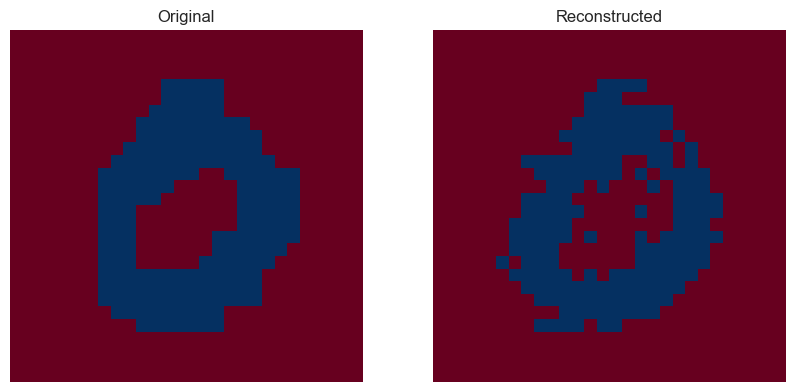

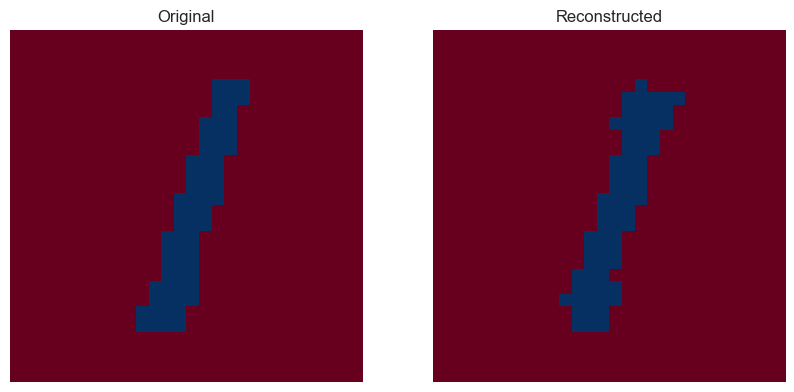

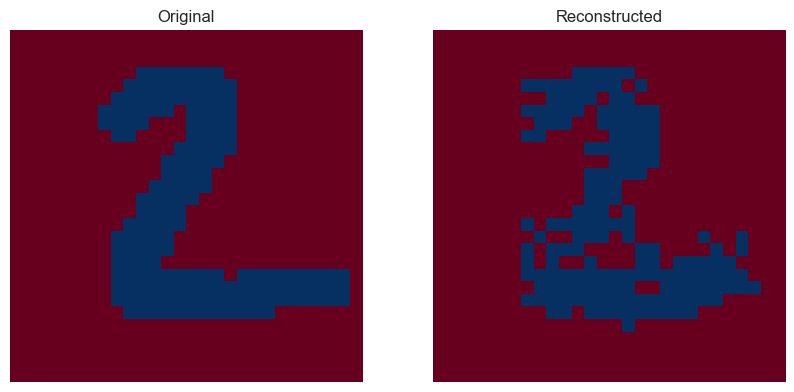

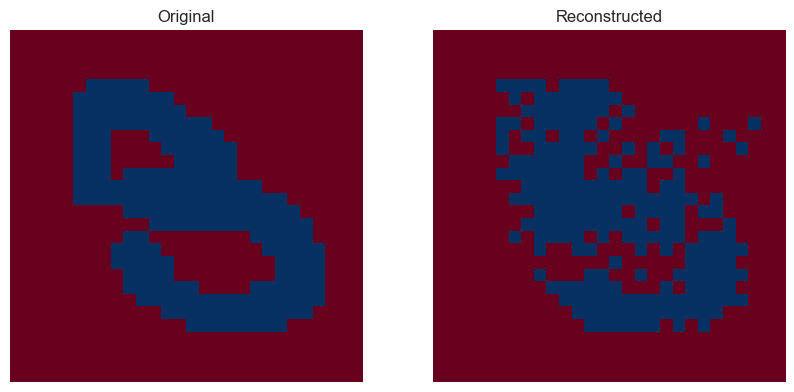

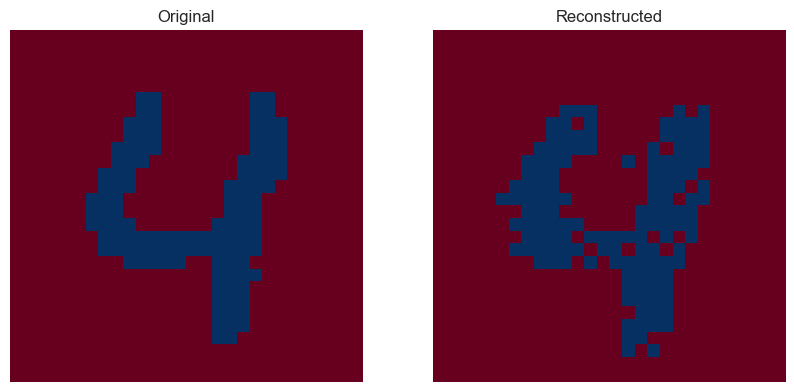

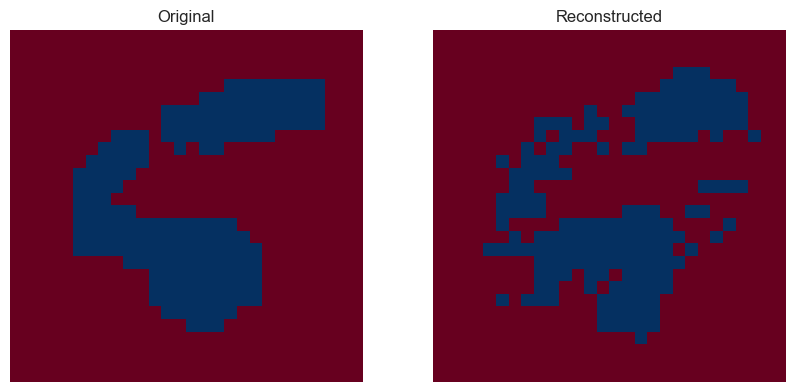

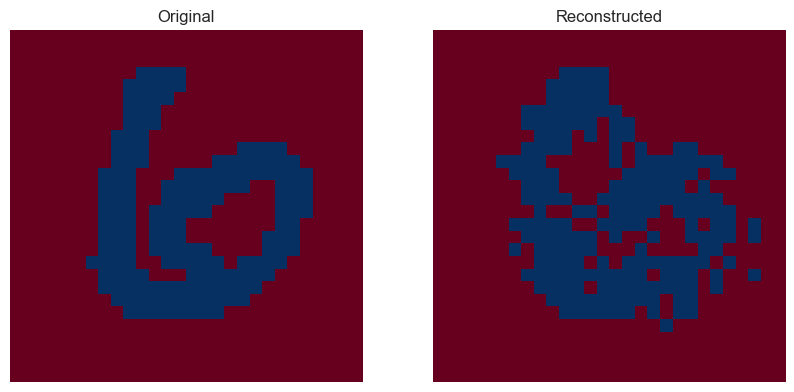

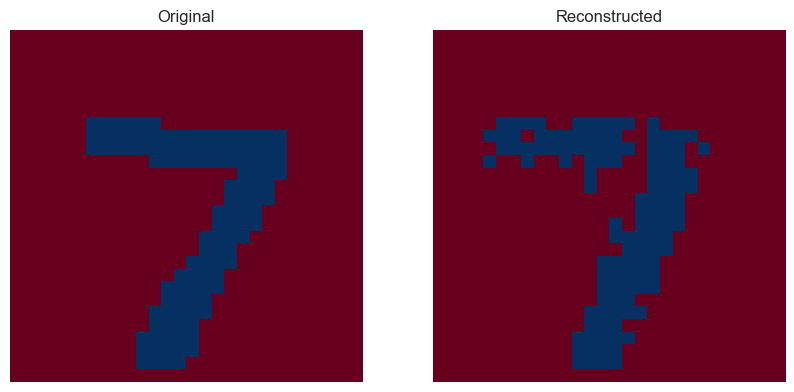

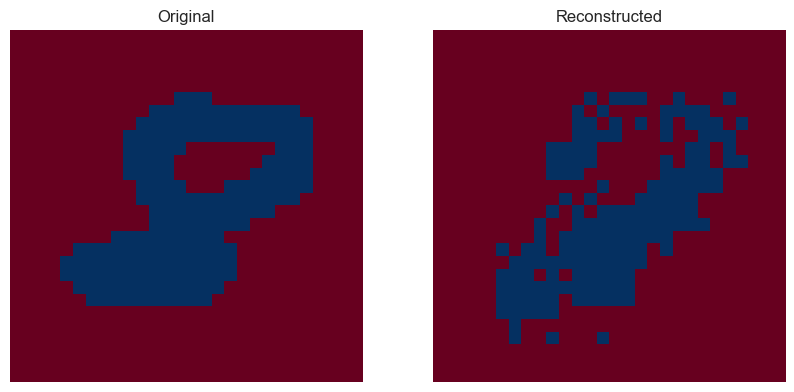

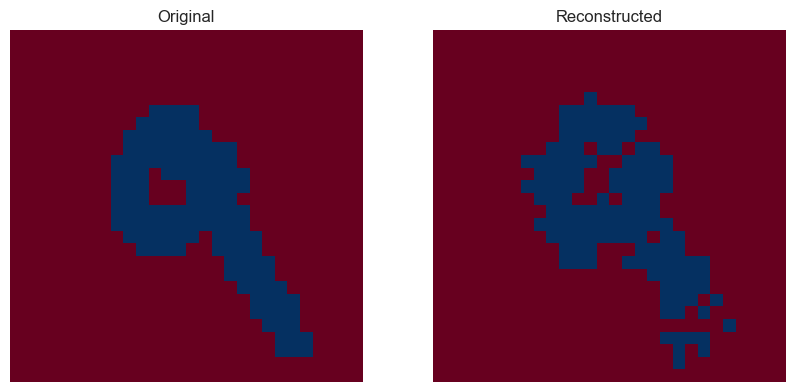

In [31]:
x_test, y_test = mnist('test')
_, indices = np.unique(y_test, return_index=True)
rbm = RestrictedBoltzmannMachine.from_components('model/rbm.npz')
pred = rbm.predict(x_test[indices], plot=True)


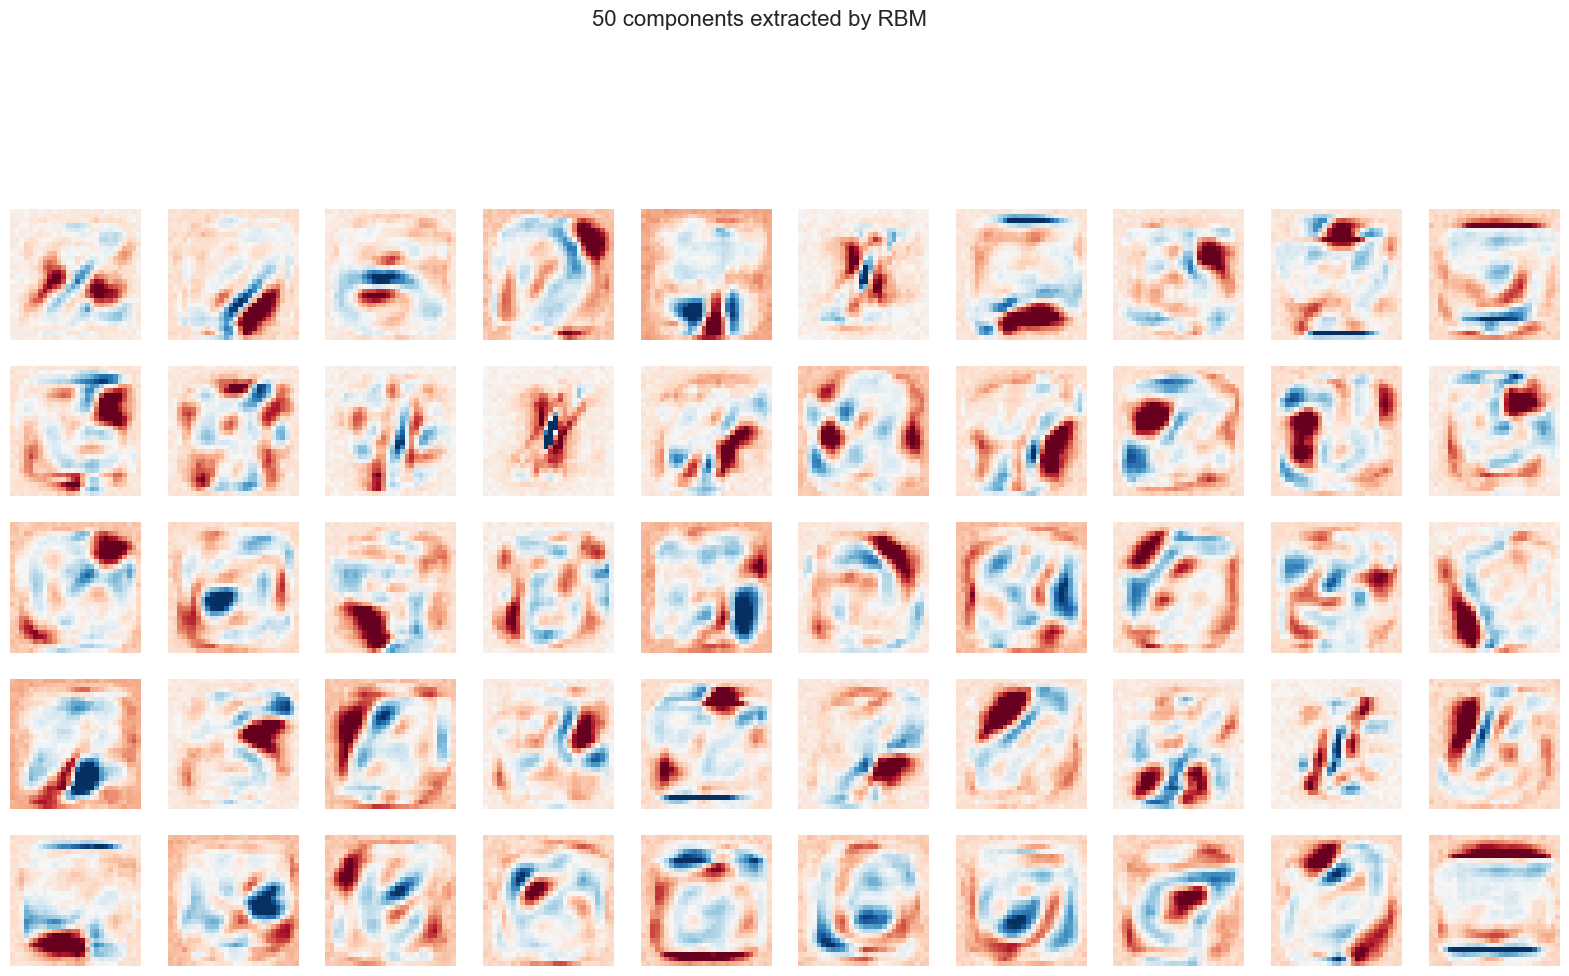

In [32]:
rbm.plot_components()

In [36]:
feed_forward = K.models.Sequential()
feed_forward.add(K.layers.Dense(256, input_dim=50, activation='relu'))
feed_forward.add(K.layers.Dense(128, activation='relu'))
feed_forward.add(K.layers.Dense(64, activation='relu'))
feed_forward.add(K.layers.Dense(10, activation='softmax'))
feed_forward.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
feed_forward.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               13056     
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 10)                650       
                                                                 
Total params: 54858 (214.29 KB)
Trainable params: 54858 (214.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
x_train, y_train = mnist('training')
encoded_train = rbm.predict_hidden(x_train)
encoded_test = rbm.predict_hidden(x_test)
x_train, x_val, y_train, y_val = train_test_split(encoded_train, y_train, test_size=0.1, random_state=42)


In [38]:
feed_forward.fit(
    x_train, 
    y_train, 
    epochs=50, 
    batch_size=100, 
    validation_data=(x_val, y_val),
    callbacks=[
        K.callbacks.EarlyStopping(patience=5, monitor='val_loss'), 
    ],
    verbose=1
)
feed_forward.save('model/feed_forward.h5')

Epoch 1/50
540/540 [==============================] - 1s 1ms/step - loss: 0.4647 - accuracy: 0.8562 - val_loss: 0.3084 - val_accuracy: 0.9020
Epoch 2/50
540/540 [==============================] - 1s 1ms/step - loss: 0.2887 - accuracy: 0.9069 - val_loss: 0.2701 - val_accuracy: 0.9160
Epoch 3/50
540/540 [==============================] - 1s 1ms/step - loss: 0.2576 - accuracy: 0.9141 - val_loss: 0.2618 - val_accuracy: 0.9160
Epoch 4/50
540/540 [==============================] - 1s 1ms/step - loss: 0.2378 - accuracy: 0.9215 - val_loss: 0.2558 - val_accuracy: 0.9188
Epoch 5/50
540/540 [==============================] - 1s 1ms/step - loss: 0.2257 - accuracy: 0.9250 - val_loss: 0.2466 - val_accuracy: 0.9230
Epoch 6/50
540/540 [==============================] - 1s 1ms/step - loss: 0.2157 - accuracy: 0.9283 - val_loss: 0.2541 - val_accuracy: 0.9207
Epoch 7/50
540/540 [==============================] - 1s 1ms/step - loss: 0.2036 - accuracy: 0.9324 - val_loss: 0.2535 - val_accuracy: 0.9208
Epoch 

In [39]:
model = K.models.load_model('model/feed_forward.h5')
res = model.evaluate(encoded_test, y_test)
accuracy = res[1] * 100
print(f'Accuracy: {accuracy:.2f}%')

313/313 [==============================] - 0s 434us/step - loss: 0.2425 - accuracy: 0.9265
Accuracy: 92.65%
